# Background

This notebook compares performance of different execution methods depending on size of the order. Due to computational and data contraints, I conduct all tests on IEO ETF (BBG: DJSOEPT, traded on Cboe) but they could well be applied to any liquid LOB-traded instrument.


# Data Preparation

## Load L3 data


In [40]:
import datetime

import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import sklearn
import sklearn.linear_model

import matplotlib.pyplot as plt
import seaborn as sns

import databento
from databento_dbn import FIXED_PRICE_SCALE
import lob3 as lob

sns.set(rc={'figure.figsize': (12, 8)})


In [4]:
#data1 = databento.DBNStore.from_file("ieo-mbo-2023-09-24")
#data1.to_df().describe()
#data2 = databento.DBNStore.from_file("ieo-mbo-2023-10-02")
#data3 = databento.DBNStore.from_file("amd-mbo-2023-09-19")

data3 = databento.DBNStore.from_file("eio-mbo-5m-2023-03-28-to-10-01")

In [5]:
# Extract best bid, offer, trades, etc. using simplifed (inefficient) LOB model

book = lob.Book()
book_is_ready = False
quotes = 0

missing_side = 0

bb_series = []
bb_sz_series = []
bo_series = []
bo_sz_series = []
ts_series = []

fill_vol_series = []
trade_vol_series = []
ts_vol_series = []

# unused
price_vol_series = []
bb_vol_series = []
bb_sz_vol_series = []
bo_vol_series = []
bo_sz_vol_series = []
prev_bb = np.nan
prev_bb_sz = np.nan
prev_bo = np.nan
prev_bo_sz = np.nan


#for data in [data1, data2]:
for data in [data3]:
    for mbo in data:

        if mbo.action == "T" or mbo.action == "F":
            ts_vol_series.append(mbo.hd.ts_event)
            if mbo.action == "T":
                trade_vol_series.append(mbo.size)
            else:
                trade_vol_series.append(np.nan)
            if mbo.action == "F":
                fill_vol_series.append(mbo.size)
            else:
                fill_vol_series.append(np.nan)
            price_vol_series.append(float(mbo.price) / FIXED_PRICE_SCALE)

            bb_vol_series.append(prev_bb)
            bb_sz_vol_series.append(prev_bb_sz)
            bo_vol_series.append(prev_bo)
            bo_sz_vol_series.append(prev_bo_sz)

        book.apply(mbo.hd.ts_event, mbo.action, mbo.side,
                   mbo.order_id, mbo.price, mbo.size)
        book_is_ready = mbo.flags & databento.RecordFlags.F_LAST

        if not book_is_ready:
            # Some events are split into two rows.
            continue

        best_bid, best_offer = book.bbo()
        quotes += 1

        if (best_offer.price == None) or (best_bid.price == None):
            missing_side += 1
            continue

        prev_bb = float(best_bid.price) / FIXED_PRICE_SCALE
        prev_bb_sz = best_bid.size
        prev_bo = float(best_offer.price) / FIXED_PRICE_SCALE
        prev_bo_sz = best_offer.size

        ts_series.append(mbo.hd.ts_event)
        bb_series.append(float(best_bid.price) / FIXED_PRICE_SCALE)
        bb_sz_series.append(best_bid.size)
        bo_series.append(float(best_offer.price) / FIXED_PRICE_SCALE)
        bo_sz_series.append(best_offer.size)

print("Datapoints: ", quotes)
print("Missing side: ", missing_side)

df_raw = pd.DataFrame({"bb": bb_series, "bo": bo_series, "bb_sz": bb_sz_series,
                       "bo_sz": bo_sz_series}, index=pd.to_datetime(ts_series, unit='ns'))

df_vol_raw = pd.DataFrame({"fill_vol": fill_vol_series, "trade_vol": trade_vol_series, "price": price_vol_series,
                          "bb" : bb_vol_series, "bb_sz": bb_sz_vol_series,
                          "bo": bo_vol_series, "bo_sz": bo_sz_vol_series},

                          index=pd.to_datetime(ts_vol_series, unit='ns'))

df_raw.index.name = "timestamp"
df_vol_raw.index.name = "timestamp"


Datapoints:  1519859
Missing side:  2139


## Cleaning


Basic exploration shows that some suspicious ticks have found their way into the dataset.


In [6]:
df_raw[df_raw["bb"] >= df_raw["bo"]]


,bb,bo,bb_sz,bo_sz
timestamp,,,,
2023-05-11 18:13:45.674257844,80.00,79.84,1,300
2023-05-11 18:13:58.786795040,80.01,79.84,2,300
2023-05-11 18:37:38.864331026,80.21,80.16,33,300
2023-09-29 19:58:51.046801066,97.52,97.52,5,400
2023-09-29 19:58:51.101385829,97.52,97.52,5,400
2023-09-29 19:58:51.101466689,97.52,97.52,5,400
2023-09-29 19:58:51.109964615,97.52,97.52,5,400
2023-09-29 19:58:52.554387010,97.52,97.52,5,400
2023-09-29 19:58:52.554387010,97.52,97.52,5,400


These seem to come from auction. Open auction ends at 9:30 ET (13:30 UTC) and the closing auction starts at 3 ET (19:00 UTC). Luckily, entire dataset fits within the daylight time (EDT). Let's filter everything outside this interval out.

Furthermore, trading around the open and close has idiosyncrasies. Market makers are more cautious during the open. Other participants try to minimize overnight exposure during close. It could certainly be modelled but let's focus on the simpler intraday case.

Thus, let's filter out all the data outside 13:40 - 18:50, and all other closed ticks (auction triggered by circuit breakers?).


In [7]:
lower_bound = datetime.time(13, 40)
upper_bound = datetime.time(18, 50)


def f(x): return lower_bound <= x.time() <= upper_bound

df_chopped = df_raw[df_raw.index.map(f)]
df = df_chopped[df_chopped["bb"] < df_chopped["bo"]]

df_vol = df_vol_raw[df_vol_raw.index.map(f)]


## Monotonicity 

Ensure monotonicity of the timestamps.

In [8]:
print("Is monotonic:", df.index.is_monotonic_increasing)
df = df.sort_index()
print("Is monotonic:", df.index.is_monotonic_increasing)


Is monotonic: False
Is monotonic: True


# Initial Exploration

## Downsample and chart best bid, best ask


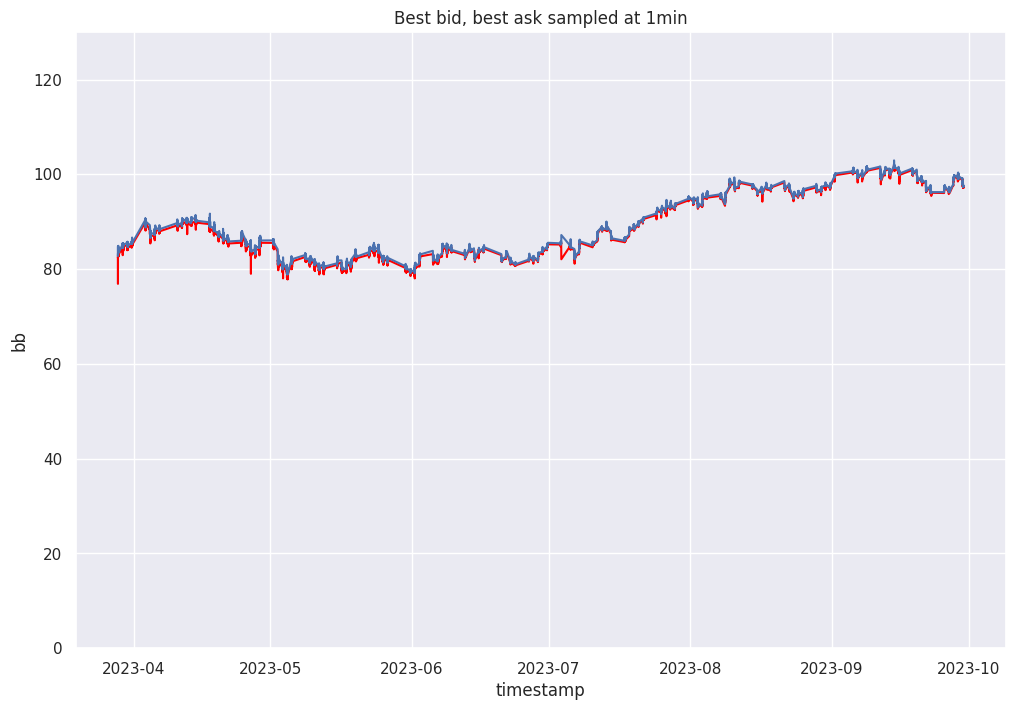

In [9]:
df_1min = df.resample("1min").mean()
df_1min.describe()

sns.lineplot(data=df_1min, y='bb', x="timestamp", color="red")
p = sns.lineplot(data=df_1min, y='bo', x="timestamp")

p.set(title="Best bid, best ask sampled at 1min")
p.set(ylim=(0, 130));


## Bid-ask spread


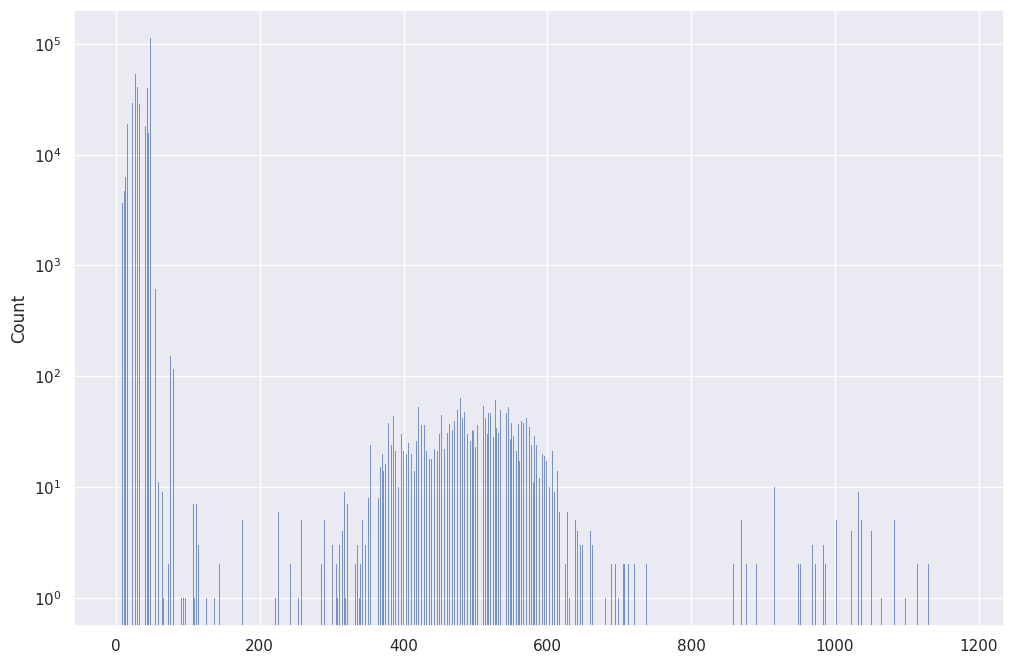

In [10]:
spread = (df["bo"] - df["bb"]) * 100

p = sns.histplot(data=spread, log_scale=False)
p.set_yscale('log')


In [11]:
print("Mean spread (ticks): ", round(spread.mean()))

Mean spread (ticks):  37


The spread is high on average and has a tail of extreme values. A simple liquidity-taking execution is going to be expensive, thus motivating consideration of more sophisticated approaches.

## Volume: visible and hidden orders


CBOE offers two kinds of obfuscated orders: iceberg, hidden. Both hide the actual size of orders from other participants. Generally, such orders are not present in the LOB at all but we can get some idea about them by looking at trades without associated fills. 

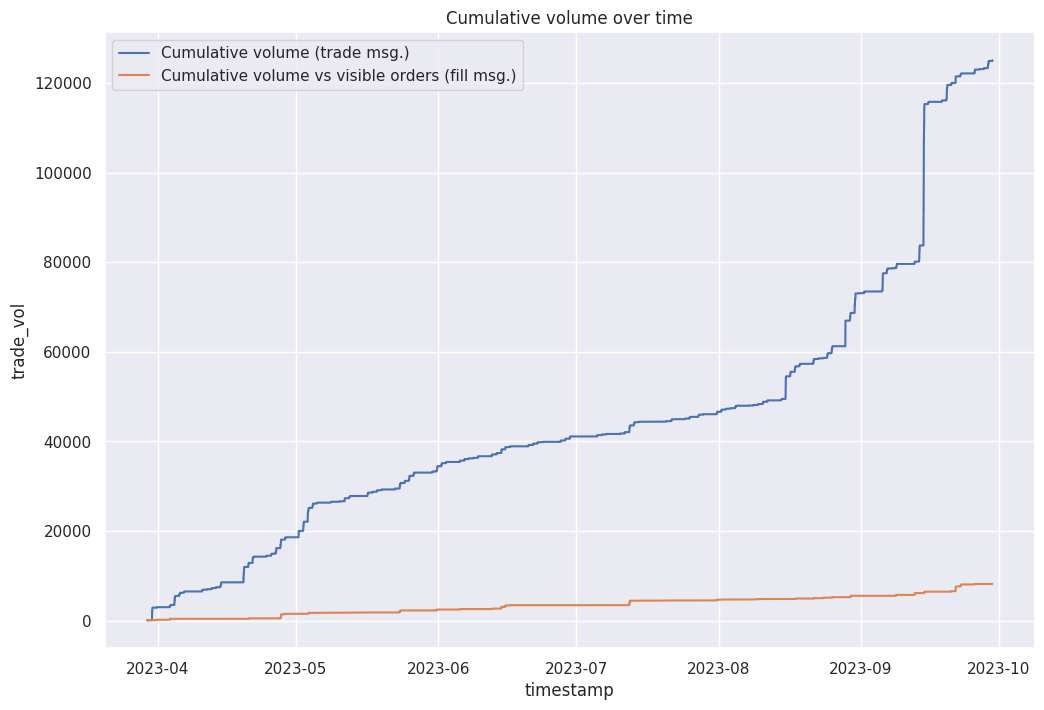

In [12]:
df_vol_1min = df_vol.resample("1min").sum()
df_vol_1min_cumsum = df_vol_1min.cumsum(axis=0)

p = sns.lineplot(data=df_vol_1min_cumsum, x="timestamp", y="trade_vol",
                 legend="brief", label="Cumulative volume (trade msg.)")
p = sns.lineplot(data=df_vol_1min_cumsum, x="timestamp", y="fill_vol",
                 legend="brief", label="Cumulative volume vs visible orders (fill msg.)")
p.set(title="Cumulative volume over time");


In [13]:
last_row = df_vol_1min_cumsum.tail(1)
cum_fill_vol = last_row["fill_vol"][0]
cum_trade_vol = last_row["trade_vol"][0]

print("Volume executed vs visible liquidity over total volume: " +
      str(round(cum_fill_vol / cum_trade_vol * 100, 2) ) + "%.")


Volume executed vs visible liquidity over total: 6.56%.


Vast majority of the taking flow seems to execute against hidden orders. The 6.5% seems lower than expected (see e.g. [U.S. Exchanges Hidden Volume (%)](https://www.sec.gov/marketstructure/datavis/ma_exchange_hiddenvolume.html)) but the support of DataBento confirmed by interpreation.


Some exchanges put restrictions on the hidden orders, i.e. they have lower priority in the queue or they are revealed when at the top of the book. CBOE seems to be particularly liberal. Consider the following trades:

In [14]:
df_vol[10:15]

,fill_vol,trade_vol,price,bb,bb_sz,bo,bo_sz
timestamp,,,,,,,
2023-03-30 18:20:28.828032410,NaN,300.0,84.72,84.59,1400,84.74,2
2023-03-30 18:20:28.828259584,NaN,100.0,84.73,84.59,1400,84.92,1400
2023-03-30 18:20:28.828450300,NaN,1.0,84.73,84.59,1400,84.92,1400
2023-03-30 18:20:28.828478156,NaN,1.0,84.73,84.59,1400,84.92,1400
2023-03-30 18:20:28.829367172,NaN,200.0,84.72,84.59,1400,84.92,1400


In all cases, the execution price is better than the visible bid-ask! Thus, the book contains entire levels of hidden liquidity. Furthermore, given that 93.4% vol is served by hidden liquidity, the true spread is likely to be significantly narrower than the visible one.

## Bid-ask spread implied by trades

While the true spread is not advertised, we can try to estimate it based on trade history. 

Sadly, the trades executed vs hidden are not annotated with side. We can try to guess the direction based on deviation from visible mid-price. Naturally, we'll miscategorize the trade if hidden liquidity on one of the sides covers more than half of the spread, but that should not be a common occurrence. The risk of that should be even lower when live, as we'll have more information from interacting with the market.

This procedure also assumes some balance between buys and sells - in such circumstances, the errors coming from mid price estimation should cancel out.

In [15]:
# Compute the distance between execution price and spread
paid_off_mid = []
order_sz = []
timestamps = []

for timestamp, row in df_vol.iterrows():

    if not np.isnan(row["fill_vol"]):
        continue

    if (row["price"] < row["bb"] or row["bo"] < row["price"]):
        continue

    midpoint = (row["bo"] + row["bb"])/2
    paid_extra = abs(midpoint - row["price"])

    paid_off_mid.append(paid_extra)
    order_sz.append(row["trade_vol"])
    timestamps.append(timestamp)

implied_spread = pd.DataFrame({"spread": np.array(paid_off_mid) * 2 * 100, "order_sz": order_sz, "timestamp": timestamps}, index=pd.to_datetime(timestamps, unit='ns'))

In [16]:
# Drop orders, which slipped
# implied_spread_top = implied_spread.sort_values(by="spread", ascending=False).drop_duplicates(subset="timestamp")
# implied_spread_top.sort_index(inplace=True)

In [17]:
print("Mean spread (ticks): ", round(spread.mean()))
print("Mean implied spread (ticks): ", round(implied_spread["spread"].mean()))

Mean spread (ticks):  37
Mean implied spread (ticks):  11


In [18]:
# Filter outliers (8 trades executed at up to 250 ticks away from spread).

implied_spread_cleaned = pd.DataFrame.copy(implied_spread[implied_spread["spread"] <= 100])

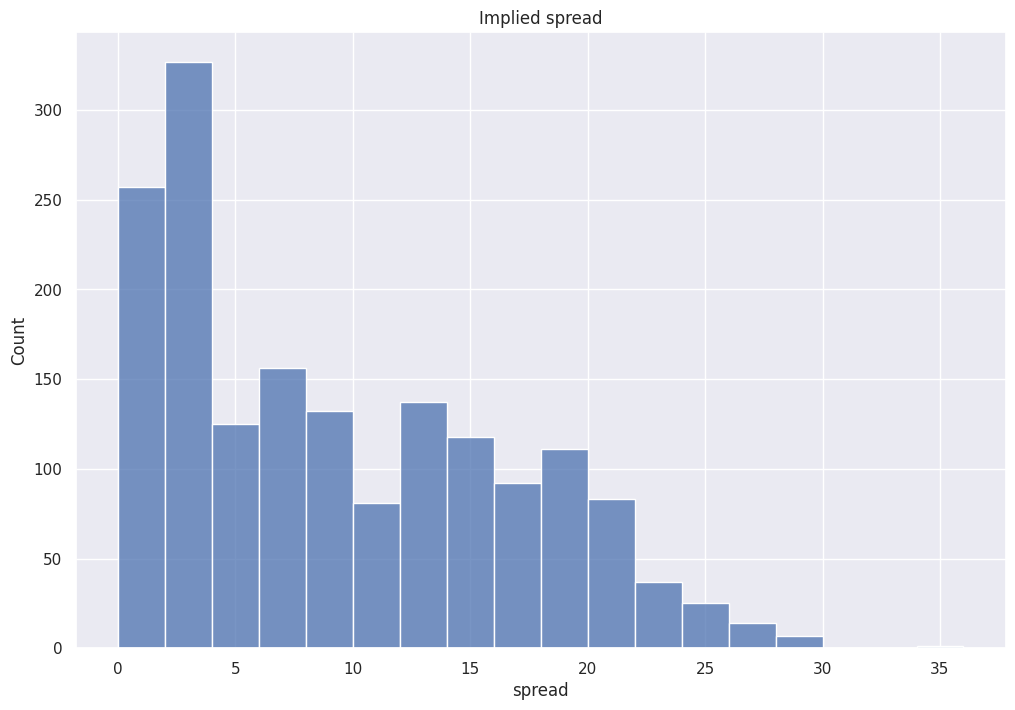

In [19]:
sns.histplot(implied_spread_cleaned["spread"]).set(title="Implied spread");

The two ouputs above confirm that trades tend to execute at significantly better prices than bid-ask. 

## Closer look on taking orderflow

It seems than rather trying to model the orderbook, we might be better off trying to model the orderflow and design the strategy based on that.  

### Order sizes

<Axes: xlabel='order_sz', ylabel='Count'>

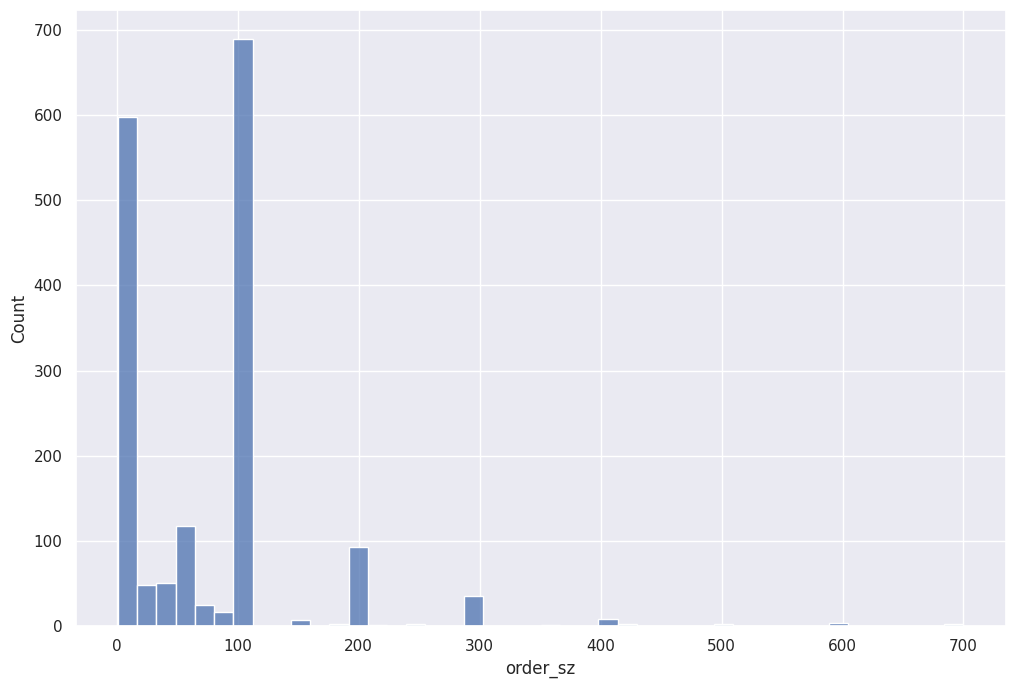

In [20]:
sns.histplot(implied_spread_cleaned["order_sz"])

The order sizes do not follow any particular distribution. The spike at 100 and multiples of rounds lots is interesting - some unsophisticated takers?  

### Order size vs premium 

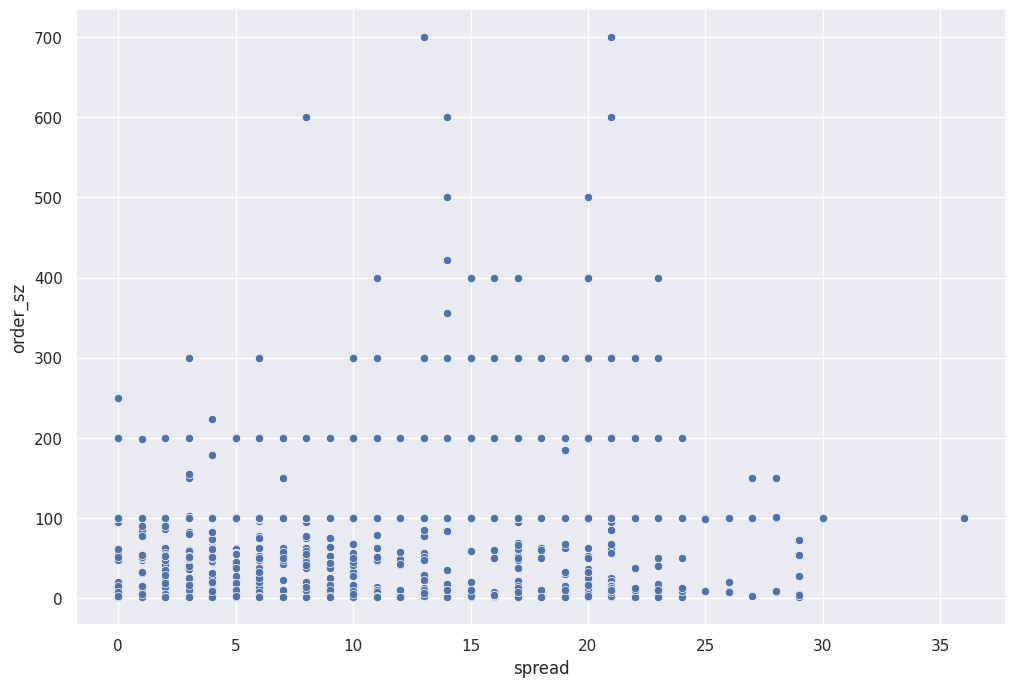

In [108]:
sns.scatterplot(data=implied_spread_cleaned, x="spread", y="order_sz");

In [22]:
scipy.stats.pearsonr(implied_spread_cleaned["spread"], implied_spread_cleaned["order_sz"])

PearsonRResult(statistic=0.21995152407406746, pvalue=4.198474777222053e-20)

There is some correlation between spread and order size. It could be due to slippage on hidden price levels, although I'm not certain - part of this might be due to confounding variables.

### Taking flow interarrival time and arrival rate

In [23]:
interarrival = pd.concat([ implied_spread_cleaned["order_sz"], implied_spread_cleaned["timestamp"],
    implied_spread_cleaned["timestamp"].shift(1).rename("lag")], axis=1)

interarrival["delta"] = interarrival["timestamp"] - interarrival["lag"]
interarrival.dropna(inplace=True)
interarrival["delta"].mean()

Timedelta('0 days 02:35:40.003672400')

In [24]:
scipy.stats.pearsonr(interarrival["delta"].astype('int64'), interarrival["order_sz"])


PearsonRResult(statistic=0.012675084162982422, pvalue=0.6012865730811845)

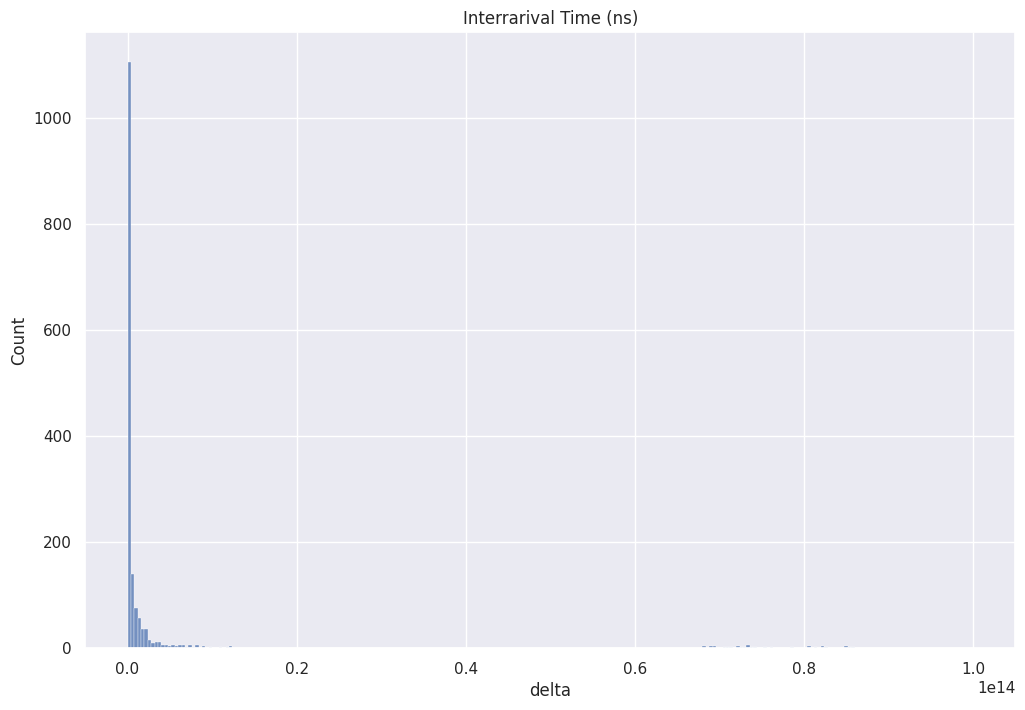

In [302]:
interarrival_int = interarrival["delta"].astype('int64')
h = sns.histplot(data=interarrival_int, bins=250, binrange=(0, 10 ** 14)).set(title="Interrarival Time (ns)")


In [26]:
implied_spread_cleaned["arrivals"] = 1
order_rate_raw = pd.DataFrame(implied_spread_cleaned["arrivals"].resample("10min").sum())
order_rate = order_rate_raw[order_rate_raw.index.map(f)]



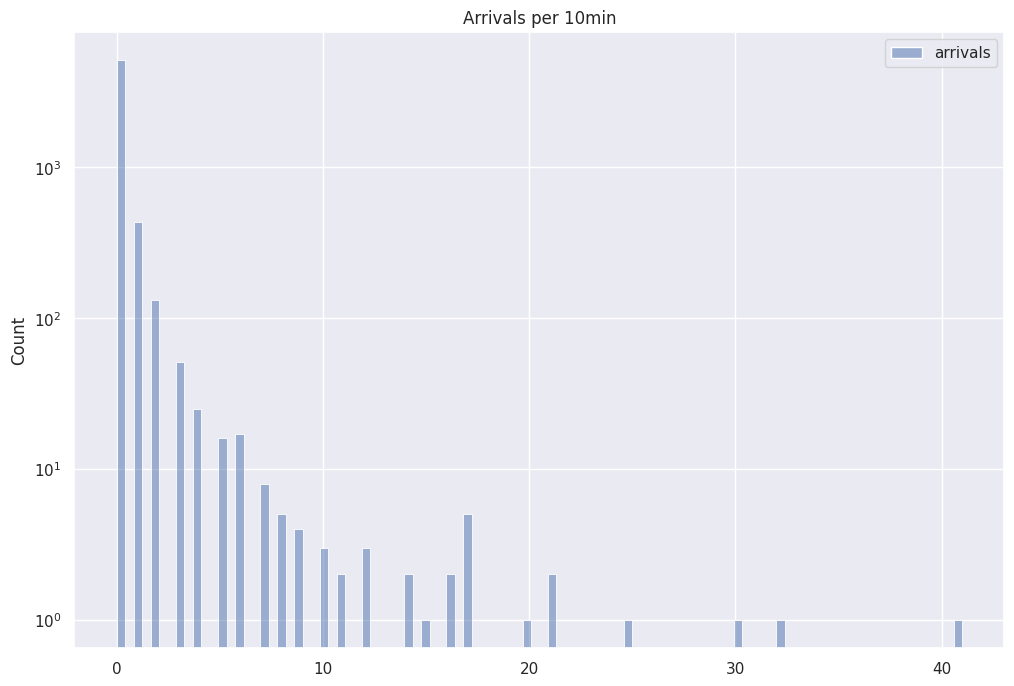

In [27]:
h = sns.histplot(data=order_rate, bins=100)
h.set_yscale('log')
h.set(title="Arrivals per 10min");


Both distributions do not seem to come from (expected) Poisson process. Rather than try to fit a well-known distribution, let's sample directly from the data and run a number of paths. 

Statistical test for Poisson distr.: 

In [28]:
exp = np.random.poisson(order_rate.mean(), order_rate.size)
sample = order_rate["arrivals"].values

min = 0
max = np.max([np.max(exp), np.max(sample)])

exp_bins, _ = np.histogram(exp, bins=20, range=(min, max))
sample_bins, _ = np.histogram(sample, bins=20, range=(min, max))

scipy.stats.chisquare(sample_bins + 0.001, exp_bins + 0.001)

Power_divergenceResult(statistic=291196.89252874645, pvalue=0.0)

# Modelling

## Prepare samplers

To run simulations we need a way to draw samples from the orderflow. Let's set up samplers for interarrival time and order sizes. As checked before, they are uncorrelated, and the samples can be generated independently.

In [29]:
orders_sz_sample = implied_spread_cleaned["order_sz"]

def init_sampler(sample):
    ecdf = sm.distributions.empirical_distribution.ECDF(sample)
    return scipy.interpolate.interp1d(ecdf(sample), sample,
                                        fill_value=(sample.min(), sample.max()), bounds_error=False)


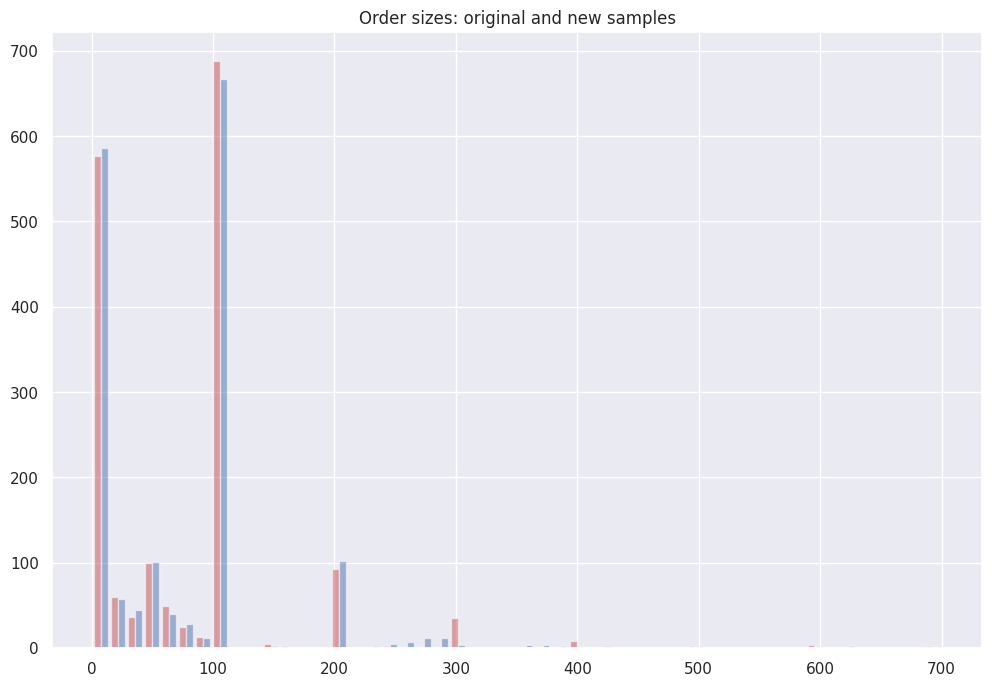

In [30]:
order_sampler = init_sampler(orders_sz_sample)
new_orders_sample = order_sampler(np.random.rand(orders_sz_sample.size))

sns.set_theme()  # <-- This actually changes the look of plots.
plt.hist([orders_sz_sample, new_orders_sample], color=['r','b'], alpha=0.5, bins=50)
plt.title('Order sizes: original and new samples');


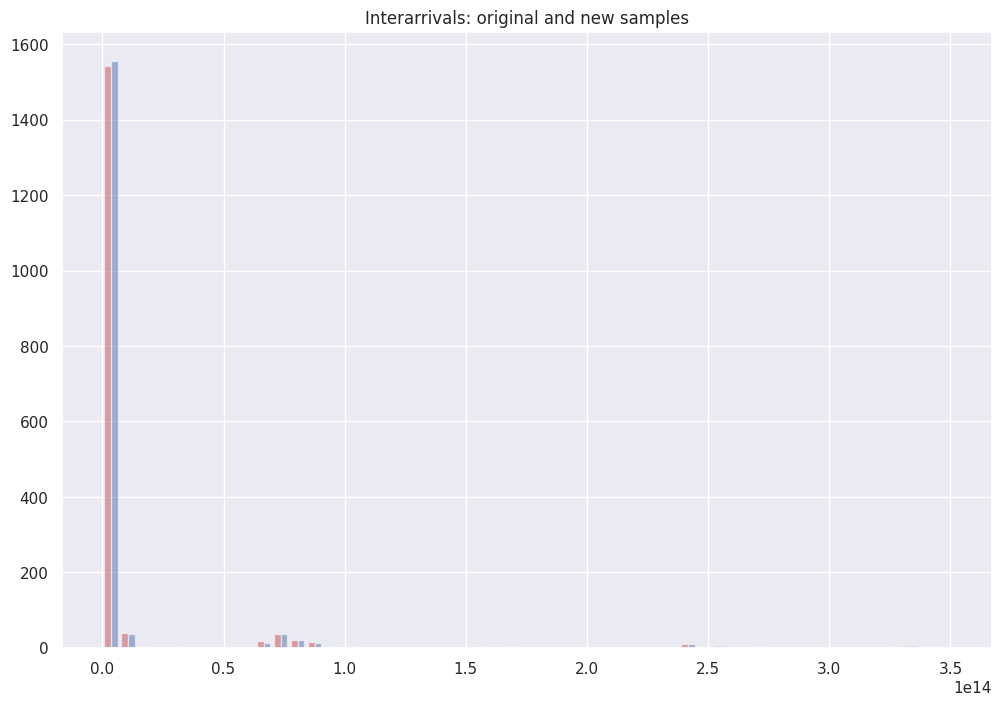

In [31]:
interarrival_sampler = init_sampler(interarrival_int)
new_interarrival_sample = interarrival_sampler(np.random.rand(interarrival_int.size))

sns.set_theme()  # <-- This actually changes the look of plots.
plt.hist([interarrival_int, new_interarrival_sample], color=['r','b'], alpha=0.5, bins=50);
plt.title('Interarrivals: original and new samples');

## Price model

The last missing bit is a model for the cost of crossing the spread. We know that it's correlated with order size. 

The correlation is stat. sign. but not strong. A potentially better approach would be to generate correlated order, premium together. For simplicity sake's, let's simply fit a linear regression.

In [115]:
#import sklearn.linear_model

X = sm.add_constant(implied_spread_cleaned["order_sz"].to_numpy())
y = implied_spread_cleaned["spread"].to_numpy()

spread_model = sm.OLS(y, X)
spread_model_fitted = spread_model.fit()


# Execution strategies

Finally, we can simulate a number of strategies.

Given a request to purchase N shares:
* Simply buy N shares. 
* Split the purchase into k taking orders s.t. it constitutes 10% of the taking orderflow.
* Split the purchase into k providing orders s.t. they capture 10% of the taking orderflow. 

All simulations assume neglible market impact. This statement should be true enough for purchases significantly smaller than a few percent of the average daily volume (>100k for IEO).

In [272]:
# Simple taking strategy
def simple_taking(order_size, _):
    return (spread_model_fitted.predict([1, order_size]) / (-2), 0)

# Spread out orders
def spread_out(rem_order_size, num_of_interarrivals):
    orders = []
    premiums = []
    interarrivals = []

    while rem_order_size > 0:
        current_order_sz = np.round( order_sampler(np.random.uniform()) )

        if current_order_sz > rem_order_size:
            current_order_sz = rem_order_size

        orders.append(current_order_sz)
        rem_order_size -= current_order_sz

        current_premium = spread_model_fitted.predict([1, current_order_sz]) / (-2)
        premiums.append(current_premium)

        current_interarrival = [interarrival_sampler(np.random.uniform()) for _ in range(0, num_of_interarrivals)]
        interarrivals.append(np.sum(current_interarrival))

    interarrivals.pop()
    total_time = np.sum(interarrivals)
    avg_premium = np.average(premiums, weights=orders, axis=0)

    return(avg_premium, total_time)

def spread_out_taking(order_size, num_of_interarrivals):
    return spread_out(order_size, num_of_interarrivals)

def spread_out_providing(order_size, num_of_interarrivals):
    premium, time = spread_out(order_size, num_of_interarrivals)
    return (-premium, time)

In [289]:
order_sizes = [1, 5, 10, 25, 50, 100, 150, 200, 400, 600]

premium_simple_taking = []
premium_simple_taking_lower = []
premium_simple_taking_upper = []
premium_simple_taking_time = []
premium_simple_taking_time_lower = []
premium_simple_taking_time_upper = []

premium_spread_taking = []
premium_spread_taking_lower = []
premium_spread_taking_upper = []
premium_spread_taking_time = []
premium_spread_taking_time_lower = []
premium_spread_taking_time_upper = []

premium_spread_providing = []
premium_spread_providing_lower = []
premium_spread_providing_upper = []
premium_spread_providing_time = []
premium_spread_providing_time_lower = []
premium_spread_providing_time_upper = []

datasets = [(premium_simple_taking, premium_simple_taking_lower,
         premium_simple_taking_upper, simple_taking, "simple taking",
         premium_simple_taking_time, premium_simple_taking_time_lower,
         premium_simple_taking_time_upper),
        (premium_spread_taking, premium_spread_taking_lower,
         premium_spread_taking_upper, spread_out_taking, "spread out taking",
         premium_spread_taking_time, premium_spread_taking_time_lower,
         premium_spread_taking_time_upper),
        (premium_spread_providing, premium_spread_providing_lower,
         premium_spread_providing_upper, spread_out_providing, "spread out providing",
         premium_spread_providing_time, premium_spread_providing_time_lower,
         premium_spread_providing_time_upper)]

for order_sz in order_sizes:
    for (premium_mean, premium_lower, premium_upper, f, _, time_mean, time_lower, time_upper) in datasets:

        premiums, times = zip(*[f(order_sz, 20) for _ in range(0, 1000)])

        premium_mean.append(np.mean(premiums))
        premium_lower.append(np.quantile(premiums, 0.05))
        premium_upper.append(np.quantile(premiums, 0.95))

        time_mean.append(np.mean(times))
        time_lower.append(np.quantile(times, 0.05))
        time_upper.append(np.quantile(times, 0.95))



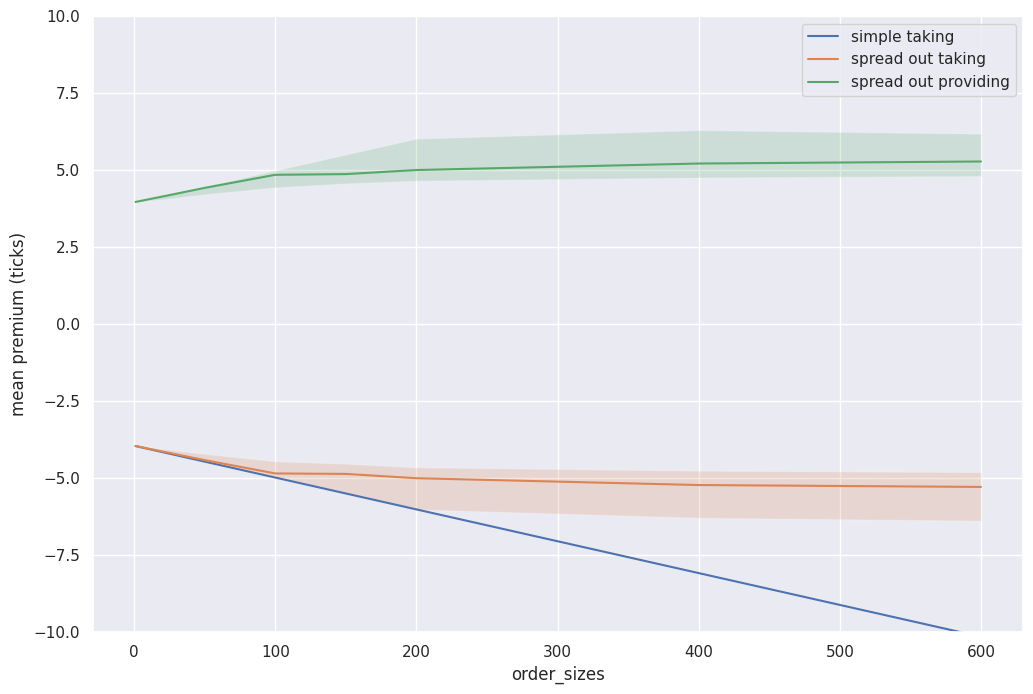

In [301]:
for (premium_mean, premium_lower, premium_upper, _, name, _, _, _) in datasets:
    data = pd.DataFrame({"order_sizes": order_sizes, "mean premium (ticks)": premium_mean})
    ax = sns.lineplot(data=data, x="order_sizes", y="mean premium (ticks)", legend='brief', label=name)
    ax.set_ylim((-10, 10))
    ax.fill_between(order_sizes, premium_lower, premium_upper, alpha=0.2)

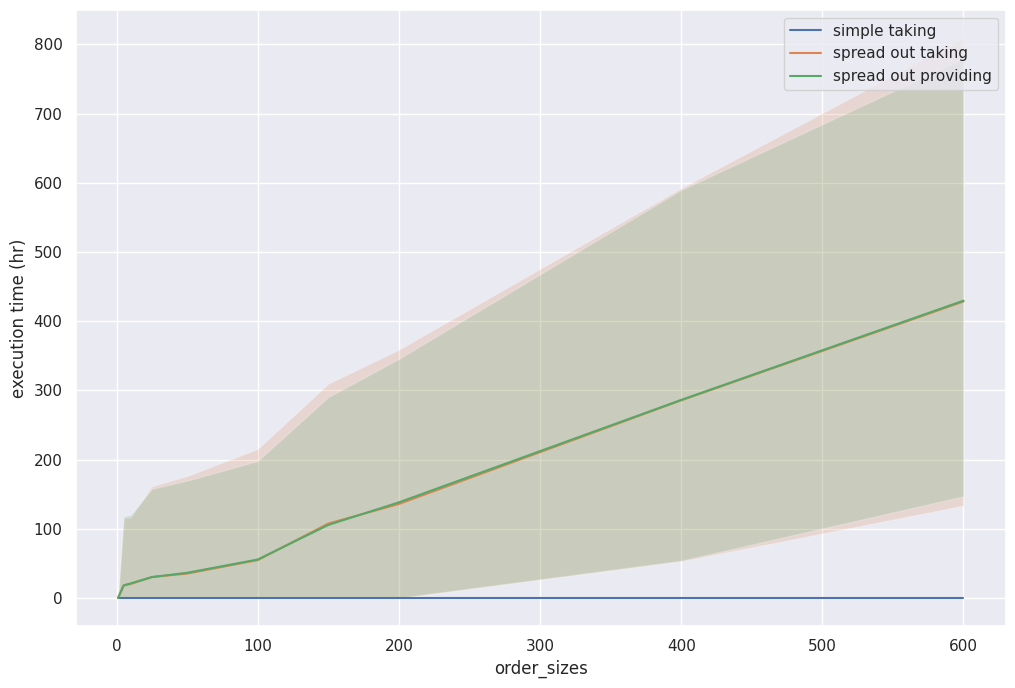

In [300]:
def timestamp_to_hr(time_mean):
    return np.array(time_mean) / (10 ** 9) / (60 * 60)

for (_, _, _, _, name, time_mean, time_lower, time_upper) in datasets:
    data = pd.DataFrame({"order_sizes": order_sizes, "execution time (hr)": timestamp_to_hr(time_mean)})
    ax = sns.lineplot(data=data, x="order_sizes", y="execution time (hr)", legend='brief', label=name)
    ax.fill_between(order_sizes, timestamp_to_hr(time_lower), timestamp_to_hr(time_upper), alpha=0.2)

To conclude, spread out execution offers a significant price advantage. In particular, for large orders and in the case of providing liquidity. However, spread out strategies are going to require a multi-day period to execute large orders (while staying at 10% of orderflow), and the exact figure will be highly variable. 

# Limitations

* Premium calculation does not model noise, which hides a lot of variability. 
* Lack of price impact.
* Direction of vast majority of the volume is inferred. Validity of that depends on lack of large imbalances in hidden liquidity. 

# Appendix: Imbalance

Adverse selection is a major concern when building liquidity-providing strategies. In light of most volume being served by hidden liquidity, does imbalance still predict near-future market moves? 

<Axes: xlabel='imbalance', ylabel='Count'>

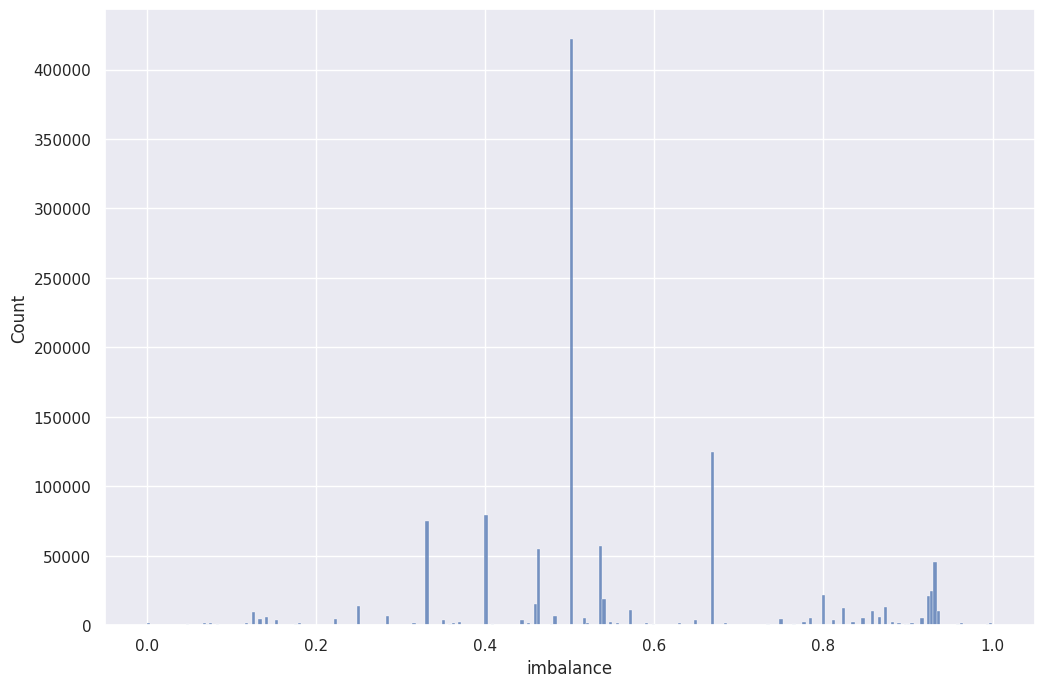

In [311]:
df["imbalance"] = df["bb_sz"] / (df["bb_sz"] + df["bo_sz"])

df["bb_prev"] = df.shift(1)["bb"]
df["bo_prev"] = df.shift(1)["bo"]

df["bb_change"] = 0
df["bo_change"] = 0

df.loc[df['bb'] > df['bb_prev'], 'bb_change'] = 1
df.loc[df['bb_prev'] > df['bb'], 'bb_change'] = -1

df.loc[df['bo'] > df['bo_prev'], 'bo_change'] = 1
df.loc[df['bo_prev'] > df['bo'], 'bo_change'] = -1

sns.histplot(data=df[df["imbalance"] != 0], x="imbalance")

In [315]:
print("Corr(imbalance, best-bid change):",scipy.stats.pearsonr(df["imbalance"], df["bb_change"]))
print("Corr(imbalance, best-offer change):",scipy.stats.pearsonr(df["imbalance"], df["bo_change"]))

Corr(imbalance, best-bid change): PearsonRResult(statistic=-0.05942404343881103, pvalue=0.0)
Corr(imbalance, best-offer change): PearsonRResult(statistic=-0.07240511485698435, pvalue=0.0)


There is a weak, but statistically significant correlation. 

In [319]:
tmp = df.query("imbalance <= 0.2 or 0.8 <= imbalance")

print("Corr(imbalance, best-bid change):",scipy.stats.pearsonr(tmp["imbalance"], tmp["bb_change"]))
print("Corr(imbalance, best-offer change):",scipy.stats.pearsonr(tmp["imbalance"], tmp["bo_change"]))

Corr(imbalance, best-bid change): PearsonRResult(statistic=-0.021882489711499226, pvalue=5.502817718851518e-26)
Corr(imbalance, best-offer change): PearsonRResult(statistic=-0.13099738806560016, pvalue=0.0)


The predictive power does increase with focusing on more extreme values. 

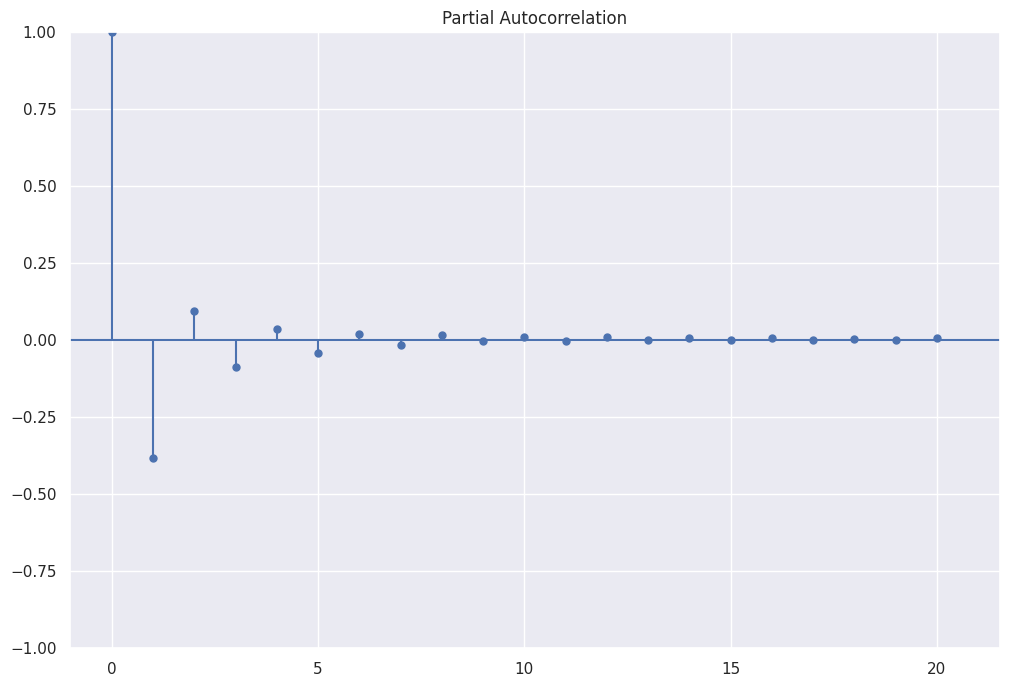

In [327]:
_ = sm.graphics.tsa.plot_pacf(df["bo_change"], lags=20)

There are significant stat. sign. partial autocorrelations with numerous lags. Thus motivating a more complex model with multiple lags.